In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from collections import defaultdict

In [5]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month + 1

In [30]:
def parse_date(dates):
    return [
        datetime.strptime(f"{d}", '%b-%y') if isinstance(d, str) 
        else float("nan") 
        for d in dates
    ]

subs = pd.read_csv(
    "user_subscriptions.csv", 
    parse_dates=["Join Date", "End Date"],
    date_parser=parse_date
)

subs["Affluence"] = subs["Affluence"].astype("category").cat.set_categories(
    ["A", "B", "C1", "C2", "DE"], ordered=True
)

subs["age"] = subs["Join Date"].dt.year - subs["BirthYear"]

subs["age_band"] = pd.cut(
    subs["age"], 
    bins=(18, 25, 35, 45, 55, 99), 
    labels=["18-24", "25-34", "35-44", "45-54", "55+"],
    include_lowest=True
)

## Customer Lifetime Value

In [31]:
def compute_tenure(row):
    end = row["End Date"]
    start = row["Join Date"]
    return diff_month(end, start)

subs["tenure"] = subs[~pd.isnull(subs["End Date"])].apply(compute_tenure, axis=1)

In [32]:
subs.loc[
    (subs["End Date"].dt.year < 2016)&
    (subs["Subscription Type"]== "Standard"), 
    "CLV"
] = subs["tenure"] * 20.99 + 5

subs.loc[
    (subs["End Date"].dt.year >= 2016)&
    (subs["Subscription Type"]== "Standard"), 
    "CLV"
] = subs["tenure"] * 26.99 + 5

subs.loc[
    (subs["End Date"].dt.year < 2016)&
    (subs["Subscription Type"]== "Flexible"), 
    "CLV"
] = subs["tenure"] * 25.99 + 5

subs.loc[
    (subs["End Date"].dt.year >= 2016)&
    (subs["Subscription Type"]== "Flexible"), 
    "CLV"
] = subs["tenure"] * 30.99 + 5

In [9]:
subs.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,tenure,CLV
CustomerID,,,,,,,,,
1,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1992,1.0,25.99
2,Greenwich,2018-06-01,A,Female,Standard,NaT,1972,NaN,NaN
3,Islington,2018-03-01,B,Female,Standard,2018-10-01,1985,8.0,220.92
4,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,1972,3.0,67.97
5,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,1982,8.0,172.92


In [10]:
subs[
    subs["End Date"].dt.year >= 2016
]["tenure"].mean()

5.062114207049001

In [11]:
subs[
    subs["End Date"].dt.year >= 2016
]["CLV"].mean()

144.4327802009795

In [12]:
subs[
    (subs["End Date"].dt.year >= 2016)&
    (subs["Subscription Type"] == "Standard")
]["CLV"].mean()

156.30276118099545

In [13]:
subs[
    (subs["End Date"].dt.year >= 2016)&
    (subs["Subscription Type"] == "Flexible")
]["CLV"].mean()

102.87051207738048

### Are some member segments more valuable than others?

#### Affluence

Not much difference, but the most affluent members do have somewhat higher CLV, and the DE group clearly has lower value.

Text(0, 0.5, 'Customer Lifetime Value')

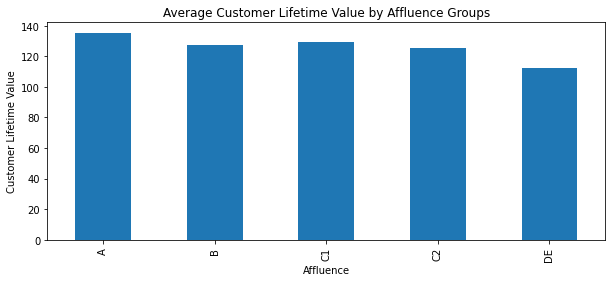

In [15]:
cust_life_val = subs.groupby('Affluence')['CLV'].mean()
ax = cust_life_val.T.plot(kind='bar', figsize = (10,4))
ylab = ax.set_ylabel('Number of Members')
plt.title('Average Customer Lifetime Value by Affluence Groups')
plt.ylabel('Customer Lifetime Value')

#### Age

CLV clearly increases with age.

Text(0, 0.5, 'Customer Lifetime Value')

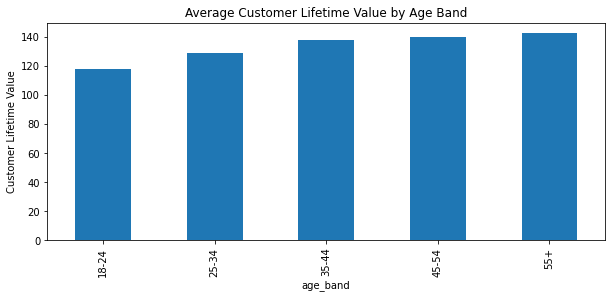

In [23]:
cust_life_val = subs.groupby('age_band')['CLV'].mean()
ax = cust_life_val.T.plot(kind='bar', figsize = (10,4))
ylab = ax.set_ylabel('Number of Members')
plt.title('Average Customer Lifetime Value by Age Band')

plt.ylabel('Customer Lifetime Value')

#### Gender

Men have slightly higher CLV than women, but not very significant.

Text(0, 0.5, 'Customer Lifetime Value')

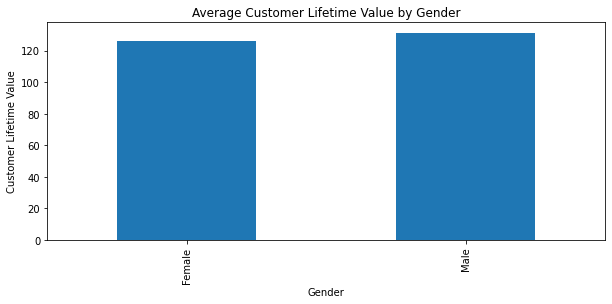

In [25]:
cust_life_val = subs.groupby('Gender')['CLV'].mean()
ax = cust_life_val.T.plot(kind='bar', figsize = (10,4))
ylab = ax.set_ylabel('Number of Members')
plt.title('Average Customer Lifetime Value by Gender')
plt.ylabel('Customer Lifetime Value')

#### Subscription types

Members with Flexible subscriptions are (unsurprisingly) less loyal than Standard subscription members, so the average CLV of Standard members is app 40% higher than Flexible members.

Text(0, 0.5, 'Customer Lifetime Value')

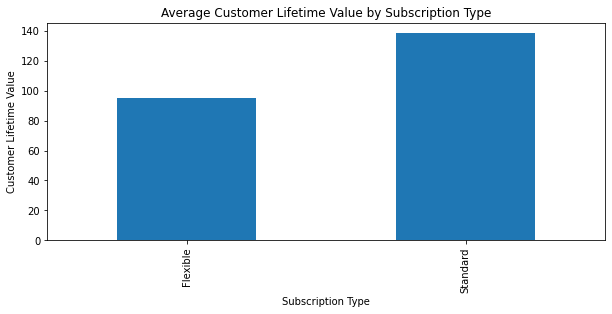

In [28]:
cust_life_val = subs.groupby('Subscription Type')['CLV'].mean()
ax = cust_life_val.T.plot(kind='bar', figsize = (10,4))
ylab = ax.set_ylabel('Number of Members')
plt.title('Average Customer Lifetime Value by Subscription Type')
plt.ylabel('Customer Lifetime Value')

### Are some member segments more price sensitive than others?

#### Affluence

If we look at how the affluence groups reacted to the Dec-15 price hike, we get the surprising result that the most affluent group was actually among the most price sensitive. As could be expected, Group B had far less terminations than continued memberships whereas Group C2 were almost all terminated. Group A, however, surprisingly had a bit higher terminations than continued memberships. This could indicate that the A members decided to move on to the more premium competitor now that the price difference was cut in half.

In [61]:
df_term = subs.copy()
df_term = df_term[
    (df_term["Join Date"] <= datetime(2015, 11, 1)) &
    (df_term["End Date"] >= datetime(2015, 12, 1))
]
df_term["Terminated_Dec-15"] = (df_term["End Date"].dt.year == 2015) & (df_term["End Date"].dt.month == 12)

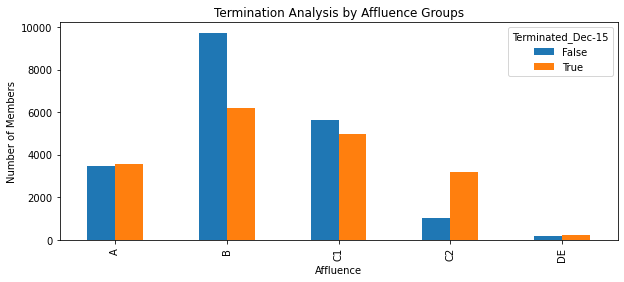

In [35]:
df_grouped2 = df_term.pivot_table(index='Terminated_Dec-15', columns='Affluence', values='CustomerID', aggfunc='count')
ax = df_grouped2.T.plot(kind='bar', title = 'Termination Analysis by Affluence Groups', figsize = (10,4))
ylab = ax.set_ylabel('Number of Members')

#### Age Band

There is a clear pattern that termination rates decrease with age, so older members seem to be less price sensitive than younger members.

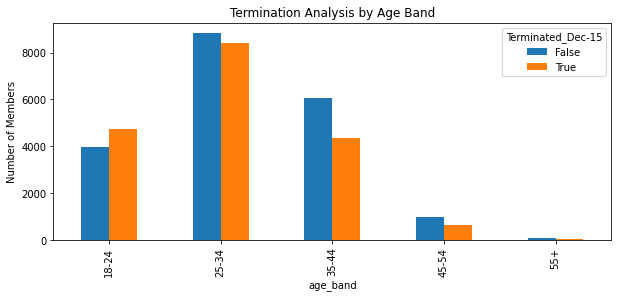

In [37]:
df_grouped2 = df_term.pivot_table(index='Terminated_Dec-15', columns='age_band', values='CustomerID', aggfunc='count')
ax = df_grouped2.T.plot(kind='bar', title = 'Termination Analysis by Age Band', figsize = (10,4))
ylab = ax.set_ylabel('Number of Members')

#### Gender

Women had a slightly higher termination rate than men in Dec-15. But as we shall see later, women generally have higher churn rates than men, so the small difference is probably not sufficient to claim there is a gender differnce in price sensitivity.

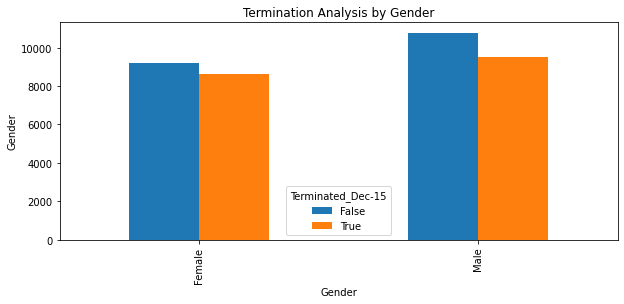

In [38]:
df_grouped2 = df_term.pivot_table(index='Terminated_Dec-15', columns='Gender', values='CustomerID', aggfunc='count')
ax = df_grouped2.T.plot(kind='bar', title = 'Termination Analysis by Gender', figsize = (10,4))
ylab = ax.set_ylabel('Gender')

#### Subscription Type

Flexible subscription members had a higher termination rate than Standard subscription members in Dec-15. But since Flexible members in general have shorter tenure than Standard members, this seems insufficient to document that Flexible members should be more price sensitive

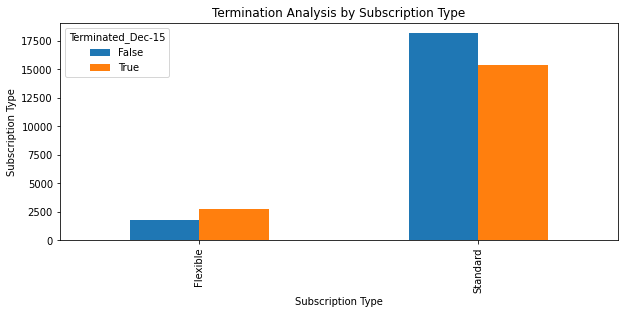

In [39]:
df_grouped2 = df_term.pivot_table(index='Terminated_Dec-15', columns='Subscription Type', values='CustomerID', aggfunc='count')
ax = df_grouped2.T.plot(kind='bar', title = 'Termination Analysis by Subscription Type', figsize = (10,4))
ylab = ax.set_ylabel('Subscription Type')

## Churn

In [60]:
def comput_churn_rates(df):
    new_customers = df.groupby("Join Date")["CustomerID"].nunique()
    lost_customers = df.groupby("End Date")["CustomerID"].nunique()
    active_customers = new_customers.cumsum() - lost_customers.cumsum()
    return lost_customers / active_customers

#### Affluence

Affluence group A has constantly had lower churn rates than all other groups. The lowest group (DE) has conversely has had much higher churn rates.

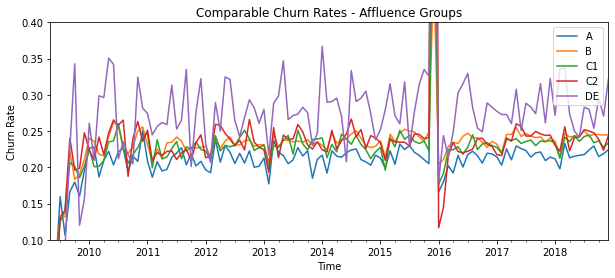

In [73]:
fig, ax = plt.subplots(figsize=(10, 4))
for g, ix in subs.groupby("Affluence").groups.items():
    comput_churn_rates(subs.loc[ix]).plot(ax=ax, label=g)
    
ax.set_title('Comparable Churn Rates - Affluence Groups')
ax.set_xlabel('Time')
ax.set_ylabel('Churn Rate')
ax.set_ylim(0.1, 0.4)
ax.legend()

#### Age

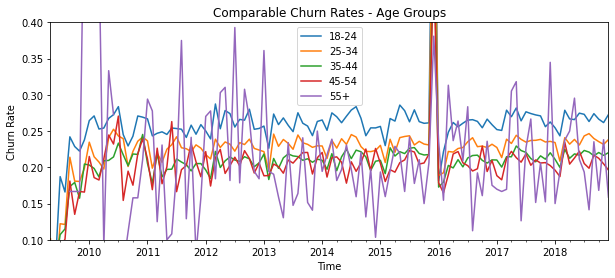

In [71]:
fig, ax = plt.subplots(figsize=(10, 4))
for g, ix in subs.groupby("age_band").groups.items():
    comput_churn_rates(subs.loc[ix]).plot(ax=ax, label=g)
    
ax.set_title('Comparable Churn Rates - Age Groups')
ax.set_xlabel('Time')
ax.set_ylabel('Churn Rate')
ax.set_ylim(0.1, 0.4)
ax.legend()

#### Gender

Women have constantly had higher churn rates than men.

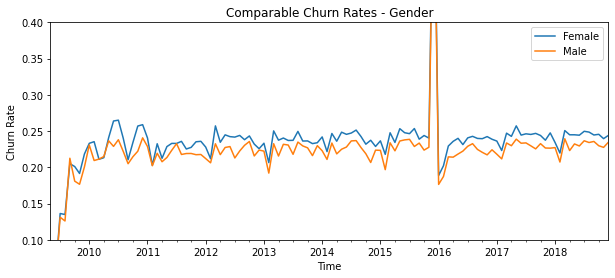

In [74]:
fig, ax = plt.subplots(figsize=(10, 4))
for g, ix in subs.groupby("Gender").groups.items():
    comput_churn_rates(subs.loc[ix]).plot(ax=ax, label=g)
    
ax.set_title('Comparable Churn Rates - Gender')
ax.set_xlabel('Time')
ax.set_ylabel('Churn Rate')
ax.set_ylim(0.1, 0.4)
ax.legend()

#### Subscription Type

As expected Flexible subscriptions have much higher churn rates than Standard subscriptions. That is sort of the nature of a Flexible subscription.

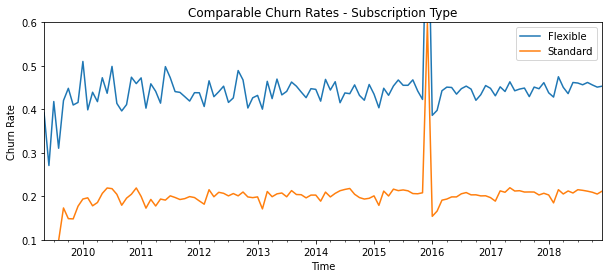

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))
for g, ix in subs.groupby("Subscription Type").groups.items():
    comput_churn_rates(subs.loc[ix]).plot(ax=ax, label=g)
    
ax.set_title('Comparable Churn Rates - Subscription Type')
ax.set_xlabel('Time')
ax.set_ylabel('Churn Rate')
ax.set_ylim(0.1, 0.6)
ax.legend()

## Revenue per year

In [43]:
def compute_revenues(data):
    revenues = defaultdict(int)
    for d in pd.date_range(start='2016-01-01', end='2018-12-31', freq="MS"):
        standard_customer_count = data[
            (data["Subscription Type"] == "Standard")&
            (data["Join Date"] <= d)&
            (data["End Date"] >= d)
        ].shape[0]
        revenues[d.year] += standard_customer_count * 26.99

        new_standard_customer_count = data[
            (data["Subscription Type"] == "Standard")&
            (data["Join Date"] == d)
        ].shape[0]
        revenues[d.year] += new_standard_customer_count * 5.

        flexible_customer_count = data[
            (data["Subscription Type"] == "Flexible")&
            (data["Join Date"] <= d)&
            (data["End Date"] >= d)
        ].shape[0]
        revenues[d.year] += flexible_customer_count * 30.99

        new_flexible_customer_count = data[
            (data["Subscription Type"] == "Flexible")&
            (data["Join Date"] == d)
        ].shape[0]
        revenues[d.year] += new_flexible_customer_count * 5.
        
    return revenues
    
revenues = compute_revenues(subs)
for year, revenue in revenues.items():
    print(f"Revenue in {year}: £{revenue:,.2f}")

Revenue in 2016: £17,702,446.85
Revenue in 2017: £21,135,579.13
Revenue in 2018: £16,909,423.11


In [66]:
mean_revenue = np.mean(list(revenues.values()))
mean_revenue

18582483.029999997

## S1 - Increase the average tenure by 1 month

In [45]:
from pandas.tseries.offsets import DateOffset

In [49]:
scenario_1 = subs.copy()

scenario_1["End Date"] += DateOffset(months=1)

In [53]:
revenues_scenario_1 = compute_revenues(scenario_1)
for year, revenue_1 in revenues_scenario_1.items():
    print(f"[S1] Revenue in {year}: £{revenue_1:,.2f} or an increase of +£{revenue_1 - revenues[year]:,.2f}")

[S1] Revenue in 2016: £21,067,139.08 or an increase of +£3,364,692.23
[S1] Revenue in 2017: £25,076,460.93 or an increase of +£3,940,881.80
[S1] Revenue in 2018: £21,072,355.17 or an increase of +£4,162,932.06


In [67]:
mean_increase = np.mean([revenues_scenario_1[y] - revenues[y] for y in revenues.keys()])

percentage_increase = mean_increase / mean_revenue
percentage_increase

0.20572252680988132

Focusing on increasing the average tenure by just one month would generate an additional average yearly revenue of **£3.8M** or **20%**.

## S2 - Reduce the number of subscriptions cancelled in December

In [59]:
scenario_2 = subs.copy()

# postpone the duration of the subscription ending in december by 3 months
scenario_2.loc[scenario_2["End Date"].dt.month == 12, "End Date"] += DateOffset(months=3)

In [60]:
revenues_scenario_2 = compute_revenues(scenario_2)
for year, revenue_2 in revenues_scenario_2.items():
    print(f"[S2] Revenue in {year}: £{revenue_2:,.2f} or an increase of +£{revenue_2 - revenues[year]:,.2f}")

[S2] Revenue in 2016: £19,253,807.42 or an increase of +£1,551,360.57
[S2] Revenue in 2017: £22,066,967.47 or an increase of +£931,388.34
[S2] Revenue in 2018: £17,923,209.57 or an increase of +£1,013,786.46


In [68]:
mean_increase = np.mean([revenues_scenario_2[y] - revenues[y] for y in revenues.keys()])

percentage_increase = mean_increase / mean_revenue
percentage_increase

0.06272099310508575

That would generate an increase of revenue of **6.3%**

## S3 - Remove Flexible subscription

We make the assumption that the Flexible members would have joined the gym anyway.

In [69]:
scenario_3 = subs.copy()

scenario_3.loc[scenario_3["Subscription Type"] == "Flexible", "End Date"] += DateOffset(months=2)
scenario_3.loc[scenario_3["Subscription Type"] == "Flexible", "Subscription Type"] = "Standard"

In [71]:
revenues_scenario_3 = compute_revenues(scenario_3)
for year, revenue_3 in revenues_scenario_3.items():
    print(f"[S3] Revenue in {year}: £{revenue_3:,.2f} or an increase of +£{revenue_3 - revenues[year]:,.2f}")

[S3] Revenue in 2016: £18,794,639.06 or an increase of +£1,092,192.21
[S3] Revenue in 2017: £22,399,497.49 or an increase of +£1,263,918.36
[S3] Revenue in 2018: £18,314,801.71 or an increase of +£1,405,378.60


In [74]:
mean_increase = np.mean([revenues_scenario_3[y] - revenues[y] for y in revenues.keys()])

percentage_increase = mean_increase / mean_revenue
percentage_increase

0.0674737451022624

That would generate an increase of revenue of **6.7%**